# Deep Mario with Random Forest
Actualizado al 25/Nov con 35 columns

In [153]:
import numpy as np
import pandas as pd
import networkx as nx
import collections 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, ParameterGrid
import multiprocessing
import warnings
import sklearn
print(sklearn.__version__) 

1.0.1


In [154]:
df = pd.read_csv("../results/results_SmallFog_X/samples.csv")
df.head()

,Sim,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,...,NextAvgRequests,NextSumLat,NextAvgLat,DstHWTotal,NextHWUsed,NextUtilization,DstDegree,DstCentrality,DstConnectedUsers,Reward
0,0,undeploy,1,medium,10,2,1,2,3,1.5,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,1,0.0
1,0,replicate,1,medium,10,2,1,2,2,1.0,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,1,0.0
2,0,migrate,1,medium,10,2,1,2,3,1.5,...,4.0,2,1.0,6.0,4,0.333333,5,0.384615,1,0.0
3,0,small,1,medium,10,2,2,2,8,4.0,...,2.0,2,1.0,2.0,1,0.500000,1,0.076923,1,1.0
4,0,large,1,medium,10,2,2,2,3,1.5,...,1.0,2,1.0,2.0,-3,2.500000,1,0.076923,1,0.0


In [155]:
df.loc[0]

Sim                             0
Action                   undeploy
App                             1
CurrentFlavour             medium
SupportedRequests              10
HWReq                           2
DifReqChannels                  1
TotReqChannels                  2
SumRequests                     3
AvgRequests                   1.5
SumLat                          6
AvgLat                        3.0
HWTotal                       2.0
HWUsed                          0
Utilization                   1.0
Degree                          1
Centrality               0.076923
ConnectedUsers                  1
DstHWUsed                       0
DstUtilization                0.0
NextSupportedRequests          10
NextHWReq                       2
NextDifReqChannels              0
NextTotReqChannels              0
NextSumRequests                 0
NextAvgRequests               0.0
NextSumLat                      0
NextAvgLat                    0.0
DstHWTotal                    2.0
NextHWUsed    

In [156]:
#dummies
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
actions = np.arange(len(actions_labels)) #dummies
df["Action"] = df["Action"].map(lambda x:actions_labels.index(x))
df["CurrentFlavour"] = df["CurrentFlavour"].map(lambda x:actions_labels.index(x))

In [157]:
df.head()

,Sim,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,...,NextAvgRequests,NextSumLat,NextAvgLat,DstHWTotal,NextHWUsed,NextUtilization,DstDegree,DstCentrality,DstConnectedUsers,Reward
0,0,0,1,2,10,2,1,2,3,1.5,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,1,0.0
1,0,5,1,2,10,2,1,2,2,1.0,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,1,0.0
2,0,4,1,2,10,2,1,2,3,1.5,...,4.0,2,1.0,6.0,4,0.333333,5,0.384615,1,0.0
3,0,1,1,2,10,2,2,2,8,4.0,...,2.0,2,1.0,2.0,1,0.500000,1,0.076923,1,1.0
4,0,3,1,2,10,2,2,2,3,1.5,...,1.0,2,1.0,2.0,-3,2.500000,1,0.076923,1,0.0


In [158]:
df = df.drop(columns="Sim") # debug columns

In [159]:
print(list(df.columns))

['Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'NextSupportedRequests', 'NextHWReq', 'NextDifReqChannels', 'NextTotReqChannels', 'NextSumRequests', 'NextAvgRequests', 'NextSumLat', 'NextAvgLat', 'DstHWTotal', 'NextHWUsed', 'NextUtilization', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']


In [160]:
# Our state is based on a set of columns
# We can remove columns with NEXT* name
state_cols = [x for x in df.columns if "Next" not in x]
print(state_cols)

['Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'DstHWTotal', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']


In [161]:
df = df.loc[:,state_cols]
df.head()

,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,SumLat,...,Degree,Centrality,ConnectedUsers,DstHWUsed,DstUtilization,DstHWTotal,DstDegree,DstCentrality,DstConnectedUsers,Reward
0,0,1,2,10,2,1,2,3,1.5,6,...,1,0.076923,1,0,0.0,2.0,1,0.076923,1,0.0
1,5,1,2,10,2,1,2,2,1.0,6,...,1,0.076923,1,0,0.0,2.0,1,0.076923,1,0.0
2,4,1,2,10,2,1,2,3,1.5,6,...,1,0.076923,1,0,0.0,6.0,5,0.384615,1,0.0
3,1,1,2,10,2,2,2,8,4.0,2,...,1,0.076923,1,0,0.0,2.0,1,0.076923,1,1.0
4,3,1,2,10,2,2,2,3,1.5,2,...,1,0.076923,1,0,0.0,2.0,1,0.076923,1,0.0


In [162]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = "Reward"),
                                        df['Reward'],
                                        random_state = 0)
print(len(X_train))
print(len(X_test))

3027
1010


In [163]:
#Training                                    
model = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [164]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df.drop(columns = "Reward").columns,
                             'importancia': model.feature_importances_}
                            )

importancia_predictores.sort_values('importancia', ascending=False)


,predictor,importancia
0,Action,0.741176
12,HWUsed,0.040122
13,Utilization,0.036411
5,DifReqChannels,0.031494
8,AvgRequests,0.023971
2,CurrentFlavour,0.023543
4,HWReq,0.021488
3,SupportedRequests,0.017776
7,SumRequests,0.014812
6,TotReqChannels,0.012454


In [165]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
0,0.514336,0.003844,Action
8,0.156342,0.001000,AvgRequests
5,0.143779,0.005768,DifReqChannels
7,0.091363,0.002383,SumRequests
12,0.084927,0.006330,HWUsed
2,0.064995,0.001451,CurrentFlavour
13,0.059876,0.003135,Utilization
6,0.055504,0.000583,TotReqChannels
3,0.054083,0.005215,SupportedRequests
4,0.053397,0.001229,HWReq


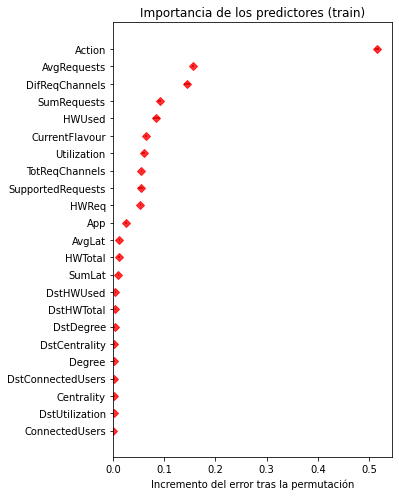

In [166]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

## TESTING

In [167]:
print(state_cols)

['Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'DstHWTotal', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']


### A valid undeploy operation

In [168]:
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]

sampleO = [actions_labels.index("undeploy"),1,actions_labels.index("small"),
           10,2, #SupRequest, HWReq
           0,0,0,0,0,0, #6 a zero REQUESTS
           20,18,0.1,2,0.8,0, # Node data
           0,0,20,2,0.8,0
          ]

fact = sampleO
print(fact)
print(len(fact))
col = df.columns[:-1]
dftest = pd.DataFrame(columns=list(col))
dftest.loc[0]=fact
dftest.head()

[0, 1, 1, 10, 2, 0, 0, 0, 0, 0, 0, 20, 18, 0.1, 2, 0.8, 0, 0, 0, 20, 2, 0.8, 0]
23


,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,SumLat,...,Utilization,Degree,Centrality,ConnectedUsers,DstHWUsed,DstUtilization,DstHWTotal,DstDegree,DstCentrality,DstConnectedUsers
0,0.0,1.0,1.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.1,2.0,0.8,0.0,0.0,0.0,20.0,2.0,0.8,0.0


In [169]:
forecasting = model.predict(X = dftest)
print(forecasting)

[1.]


In [170]:
# Iterating on all actions
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
for i in range(len(actions_labels)):
    print(" Action: %s"%actions_labels[i])
    sampleO = [i,1,actions_labels.index("small"),
               10,2, #SupRequest, HWReq
               0,0,0,0,0,0, #6 a zero REQUESTS
               20,18,0.1,2,0.8,0, # Node data
               0,0,20,2,0.8,0
              ]
    fact = sampleO
    col = df.columns[:-1]
    dftest = pd.DataFrame(columns=list(col))
    dftest.loc[0]=fact
    forecasting = model.predict(X = dftest)
    print(forecasting)

 Action: undeploy
[1.]
 Action: small
[0.]
 Action: medium
[0.]
 Action: large
[0.02]
 Action: migrate
[0.]
 Action: replicate
[0.]


### Testing all Rewards a 1

In [171]:
dd = df[df.Reward>0]
len(dd)

967

In [172]:
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
acts = collections.defaultdict(list)
col = df.columns[:-1]
for ix,row in dd.iterrows():
    sample = row.values[:-1]
    print(sample)
    print("Service flavour: %s + Action: %s = Reward: %0.3f"%
          (actions_labels[int(sample[2])],actions_labels[int(sample[0])],
           row.values[-1])) # the action
    for i in range(len(actions_labels)):
        dftest = pd.DataFrame(columns=list(col))
        sample[2] = i #action is the new action
        dftest.loc[0]=sample
       # print(dftest)
        forecasting = model.predict(X = dftest) #¡OBVIAMENTE PODRIA HACER UNA PREDCCION SOBRE UN GRAN DATAFRAME....
        print("\tPredicción sobre acción: %s valor: %0.3f"%(actions_labels[i],forecasting[0]))
        acts[i].append(forecasting[0])
    break
    


[ 1.          1.          2.         10.          2.          2.
  2.          8.          4.          2.          1.          2.
  0.          1.          1.          0.07692308  1.          0.
  0.          2.          1.          0.07692308  1.        ]
Service flavour: medium + Action: small = Reward: 1.000
	Predicción sobre acción: undeploy valor: 0.500
	Predicción sobre acción: small valor: 0.500
	Predicción sobre acción: medium valor: 1.000
	Predicción sobre acción: large valor: 1.000
	Predicción sobre acción: migrate valor: 1.000
	Predicción sobre acción: replicate valor: 1.000


# Observaciones
- Mejorar el indicador de bondad de esto.. jaja
- Quizás hacer más pruebas?
- Visualización?
- Valorar la accion "NADA"

In [173]:
sampleO = [ 1,          1,          2,         10,          2,          2,
  2,          8,          4,          2,          1,          2,
  0,          1,          1,          0.07692308,  1,          0,
  0,          2,          1,          0.07692308 , 1        ]